In [1]:
import heapq
import numpy as np
import scipy.sparse
from sklearn import linear_model
from copy import deepcopy
from sklearn.metrics import mean_squared_error

from utils_mondrian import sample_cut

In [2]:
def train(X, y, M, lifetime_max, delta,
          mondrian_kernel=False, mondrian_forest=False, weights_from_lifetime=None, importance = True):
    """
    Sweeps through Mondrian kernels with all lifetime in [0, lifetime_max]. This can be used to (1) construct a Mondrian
    feature map with lifetime lifetime_max, to (2) find a suitable lifetime (inverse kernel width), or to (3) compare
    Mondrian kernel to Mondrian forest across lifetimes.
    :param X:                       training inputs
    :param y:                       training regression targets
    :param M:                       number of Mondrian trees
    :param lifetime_max:            terminal lifetime
    :param delta:                   ridge regression regularization hyperparameter
    :param mondrian_kernel:         flag indicating whether mondrian kernel should be evaluated
    :param mondrian_forest:         flag indicating whether mondrian forest should be evaluated
    :param weights_from_lifetime:   lifetime at which forest and kernel learned weights should be saved
    :return: dictionary res containing all results
    """
    
    N, D = np.shape(X)
    history = []

    if mondrian_forest or mondrian_kernel:
        y = np.squeeze(y)

        # subtract target means
        y_mean = np.mean(y)
        y_train = y - y_mean

    # initialize sparse feature matrix
    indptr = range(0, M * N + 1, M)
    indices = list(range(M)) * N
    data = np.ones(N * M) / np.sqrt(M)
    Z_all = scipy.sparse.csr_matrix((data, indices, indptr), shape=(N, M))
    feature_from_repetition = list(range(M))
    C = M
    X_bd_all = np.tile(X, (M*D,1)).reshape(M,D,N,D)

    # bounding box for all datapoints used to sample first cut in each tree
    feature_data = [np.array(range(N)) for _ in range(M)]
    lX = np.min(X, 0)
    uX = np.max(X, 0)

    # event = tuple (time, tree, feature, dim, loc), where feature is the index of feature being split
    events = []
    active_features = []
    active_features_in_tree = [[] for _ in range(M)]
    for m in range(M):
        cut_time, dim, loc = sample_cut(lX, uX, 0.0)
        if cut_time < lifetime_max:
            heapq.heappush(events, (cut_time, m, m, dim, loc))
        active_features.append(m)
        active_features_in_tree[m].append(m)

    # iterate through birth times in increasing order
    if mondrian_forest:
        w_trees = [np.zeros(1) for _ in range(M)]
        trees_y_hat_train = np.zeros((N, M))        # initialize Mondrian tree predictions and squared errors
    if mondrian_kernel:
        w_kernel = np.zeros(M)

    while len(events) > 0:
        (birth_time, m, c, dim, loc) = heapq.heappop(events)
        history.append((birth_time, m, c, dim, loc))

        # construct new feature
        Xd = X[feature_data[c], dim]
        feature_l = (feature_data[c])[Xd <= loc]
        feature_r = (feature_data[c])[Xd  > loc]
        feature_data.append(feature_l)
        feature_data.append(feature_r)

        active_features.remove(c)
        active_features_in_tree[m].remove(c)
        active_features.append(C + 0)
        active_features.append(C + 1)
        active_features_in_tree[m].append(C + 0)
        active_features_in_tree[m].append(C + 1)

        # move datapoints from split feature to child features
        Z_all.indices[feature_l * M + m] = C + 0
        Z_all.indices[feature_r * M + m] = C + 1
        Z_all = scipy.sparse.csr_matrix((Z_all.data, Z_all.indices, Z_all.indptr), shape=(N, C + 2), copy=False)

        # sample the cut for each child
        lX_l = np.min(X[feature_l, :], axis=0)
        uX_l = np.max(X[feature_l, :], axis=0)
        cut_time_l, dim_l, loc_l = sample_cut(lX_l, uX_l, birth_time)
        lX_r = np.min(X[feature_r, :], axis=0)
        uX_r = np.max(X[feature_r, :], axis=0)
        cut_time_r, dim_r, loc_r = sample_cut(lX_r, uX_r, birth_time)

        if importance and (loc_l is not None) and (loc_r is not None):
            X_bd_all[m, dim, feature_l, dim] = lX_r[dim]
            X_bd_all[m, dim, feature_r, dim] = uX_l[dim]

        # add new cuts to heap
        if cut_time_l < lifetime_max:
            heapq.heappush(events, (cut_time_l, m, C + 0, dim_l, loc_l))
        if cut_time_r < lifetime_max:
            heapq.heappush(events, (cut_time_r, m, C + 1, dim_r, loc_r))

        feature_from_repetition.append(m)
        feature_from_repetition.append(m)
        C += 2

        if mondrian_forest:
            # update Mondrian forest predictions in tree m
            Z_train = Z_all[:N, active_features_in_tree[m]]
            w_tree = np.linalg.solve(np.transpose(Z_train).dot(Z_train) + delta / M * np.identity(len(active_features_in_tree[m])),
                                np.transpose(Z_train).dot(y_train))
            if weights_from_lifetime is not None and birth_time <= weights_from_lifetime:
                w_trees[m] = w_tree / np.sqrt(M)
            trees_y_hat_train[:, m] = np.squeeze(Z_train.dot(w_tree))

        # update Mondrian kernel predictions
        if mondrian_kernel:
            w_kernel = np.append(w_kernel, [w_kernel[c], w_kernel[c]])
            w_kernel[c] = 0

            clf = linear_model.SGDRegressor(alpha=delta, fit_intercept=False)
            clf.fit(Z_all, y_train, coef_init=w_kernel)
            w_kernel = clf.coef_

    # this function returns a dictionary with all values of interest stored in it
    
    if mondrian_kernel:
        y_hat_train = y_mean + Z_all.dot(w_kernel)
    return X_bd_all, X, history, w_kernel, y_hat_train

def evaluate(X, y, X_test, M, delta, history, w_kernel,
             mondrian_kernel=False, mondrian_forest=False, weights_from_lifetime=None,):
    """
    Sweeps through Mondrian kernels with all lifetime in [0, lifetime_max]. This can be used to (1) construct a Mondrian
    feature map with lifetime lifetime_max, to (2) find a suitable lifetime (inverse kernel width), or to (3) compare
    Mondrian kernel to Mondrian forest across lifetimes.
    :param X:                       training inputs
    :param y:                       training regression targets
    :param X_test:                  test inputs
    :param y_test:                  test regression targets
    :param M:                       number of Mondrian trees
    :param lifetime_max:            terminal lifetime
    :param delta:                   ridge regression regularization hyperparameter
    :param validation:              flag indicating whether a validation set should be created by halving the test set
    :param mondrian_kernel:         flag indicating whether mondrian kernel should be evaluated
    :param mondrian_forest:         flag indicating whether mondrian forest should be evaluated
    :param weights_from_lifetime:   lifetime at which forest and kernel learned weights should be saved
    :return: dictionary res containing all results
    """
    N, D = np.shape(X)
    N_test = np.shape(X_test)[0]
    X_all = np.array(np.r_[X, X_test])
    N_all = N + N_test
    history = deepcopy(history)

    if mondrian_forest or mondrian_kernel:
        y = np.squeeze(y)

        # subtract target means
        y_mean = np.mean(y)
        y_train = y - y_mean

    # initialize sparse feature matrix
    indptr = range(0, M * N_all + 1, M)
    indices = list(range(M)) * N_all
    data = np.ones(N_all * M) / np.sqrt(M)
    Z_all = scipy.sparse.csr_matrix((data, indices, indptr), shape=(N_all, M))
    C = M

    # iterate through birth times in increasing order
    if mondrian_forest:
        w_trees = [np.zeros(1) for _ in range(M)]
        trees_y_hat_train = np.zeros((N, M))        # initialize Mondrian tree predictions and squared errors
        trees_y_hat_test = np.zeros((N_test, M))
    
    feature_data = [np.array(range(N_all)) for _ in range(M)]
    active_features = []
    active_features_in_tree = [[] for _ in range(M)]
    for m in range(M):
        active_features.append(m)
        active_features_in_tree[m].append(m)

    while len(history) > 0:
        (birth_time, m, c, dim, loc) = history.pop(0)

        # construct new feature
        Xd = X_all[feature_data[c], dim]
        feature_l = (feature_data[c])[Xd <= loc]
        feature_r = (feature_data[c])[Xd  > loc]
        feature_data.append(feature_l)
        feature_data.append(feature_r)

        active_features.remove(c)
        active_features_in_tree[m].remove(c)
        active_features.append(C + 0)
        active_features.append(C + 1)
        active_features_in_tree[m].append(C + 0)
        active_features_in_tree[m].append(C + 1)

        # move datapoints from split feature to child features
        Z_all.indices[feature_l * M + m] = C + 0
        Z_all.indices[feature_r * M + m] = C + 1
        Z_all = scipy.sparse.csr_matrix((Z_all.data, Z_all.indices, Z_all.indptr), shape=(N_all, C + 2), copy=False)

        C += 2

        if mondrian_forest:
            # update Mondrian forest predictions in tree m
            Z_train = Z_all[:N, active_features_in_tree[m]]
            Z_test = Z_all[N:, active_features_in_tree[m]]
            w_tree = np.linalg.solve(np.transpose(Z_train).dot(Z_train) + delta / M * np.identity(len(active_features_in_tree[m])),
                                np.transpose(Z_train).dot(y_train))
            if weights_from_lifetime is not None and birth_time <= weights_from_lifetime:
                w_trees[m] = w_tree / np.sqrt(M)
            trees_y_hat_train[:, m] = np.squeeze(Z_train.dot(w_tree))
            trees_y_hat_test[:, m] = np.squeeze(Z_test.dot(w_tree))

            # update Mondrian forest error
            y_hat_train = y_mean + np.mean(trees_y_hat_train, 1)
            y_hat_test = y_mean + np.mean(trees_y_hat_test, 1)

        # update Mondrian kernel predictions
    
    if mondrian_kernel:
        Z_train = Z_all[:N]
        Z_test = Z_all[N:]
        y_hat_train = y_mean + Z_train.dot(w_kernel)
        y_hat_test = y_mean + Z_test.dot(w_kernel)
    return y_hat_train, y_hat_test
    
def simulate_y(x, seed = 0, noise_sig2 = 0.0001):
    y = x[:, 0]**4 + x[:, 1]**4 + x[:, 2]**4 + x[:, 3]**4 + x[:, 4]**4
    r_noise = np.random.RandomState(seed)
    n = len(x)
    noise = r_noise.randn(n, 1) * np.sqrt(noise_sig2)
    y = y + noise[:, 0]
    return y

import matplotlib.pyplot as plt
def draw(dim_in, psi_est, labels = None):
    x = np.linspace(0, dim_in-1, dim_in)
    fig, ax = plt.subplots()

    ax.plot(x, psi_est, linewidth=1.0, label = "diag")
    if labels is not None:
        plt.xticks(x, labels)
    plt.legend()
    plt.show()

def populate_importance(subset_vector, importance):
    importance = list(importance)
    m = len(subset_vector)
    res = np.zeros(m)
    for i in range(m):
        if subset_vector[i] != 0:
            res[i] = importance.pop()
    return res


def plot_spectrum(y, y_diag, title):
    x = np.linspace(0, len(y)-1, len(y))

    fig, ax = plt.subplots()

    ax.plot(x, y, linewidth=2.0, label = "eig")
    ax.plot(x, y_diag, linewidth=2.0, label = "diagonal")

    plt.legend()
    plt.title(title)
    plt.show()

In [3]:
n = 20000
dim_in = 25
x_train = np.random.rand(n,dim_in)*2 - 1
y_train = simulate_y(x_train)

x_test = np.random.rand(5000,dim_in)*2 - 1
y_test = simulate_y(x_test)

M = 100                      # number of Mondrian trees to use
lifetime_max = 0.1          # terminal lifetime
weights_lifetime = 2*1e-6   # lifetime for which weights should be plotted
delta = 0.1              # ridge regression delta


In [6]:
def simulate(x_train, y_train, x_test, y_test):

    X_bd_all, X, history, w_kernel, y_hat_train = train(x_train, y_train, M, lifetime_max, delta, mondrian_kernel = True,
                                weights_from_lifetime=weights_lifetime)

    mean_squared_error(y_train, y_hat_train)


    importance = []
    for dim in range(dim_in):
        x_eval = None
        y_eval = []
        x_diff = []
        subset_all = []
        for tree in range(M):
            temp = X_bd_all[tree,dim] - X
            subset = temp[:,dim] != 0
            subset_all = subset_all + list(subset)
            if sum(subset) > 0:
                if x_eval is None:
                    x_eval = X_bd_all[tree,dim][subset]
                else:
                    x_eval = np.vstack((x_eval, X_bd_all[tree,dim][subset]))
                y_eval = y_eval + list(y_hat_train[subset])
                x_diff = x_diff + list(temp[:,dim][subset])

        _, y_hat_eval = evaluate(x_train, y_train, x_eval, M, delta, history, w_kernel, mondrian_kernel = True, 
                                weights_from_lifetime=weights_lifetime)
        
        importance_temp = populate_importance(subset_all, ((y_eval - y_hat_eval)/x_diff))
        importance_temp = np.reshape(importance_temp, (len(X), M))
        importance_temp = np.median(importance_temp, axis = 1)
        importance.append(importance_temp)
    importance = np.vstack(importance)

    _, y_hat_test = evaluate(x_train, y_train, x_test, M, delta, history, w_kernel, mondrian_kernel = True, 
                                weights_from_lifetime=weights_lifetime)

    mse_before = mean_squared_error(y_test, y_hat_test)

    print(f"Test mean squared error before transformation: {mse_before}")

    H = np.matmul(importance, np.transpose(importance))

    H = H * len(H) / np.trace(H)
    
    eig = np.linalg.eig(H)[0]
    y_diag = np.diagonal(H)
    plot_spectrum(eig, y_diag, 'spectrum')

    x_train_transformed = np.matmul(x_train, H)
    x_test_transformed = np.matmul(x_test, H)
    X_bd_all, X, history, w_kernel, y_hat_train = train(x_train_transformed, y_train, M, lifetime_max, delta, mondrian_kernel = True,
                                weights_from_lifetime=weights_lifetime)

    mean_squared_error(y_train, y_hat_train)

    _, y_hat_test = evaluate(x_train_transformed, y_train, x_test_transformed, M, delta, history, w_kernel, mondrian_kernel = True, 
                            weights_from_lifetime=weights_lifetime)


    mse_after = mean_squared_error(y_test, y_hat_test)

    print(f"Test mean squared error after transformation: {mse_after}")

    return mse_before, mse_after

number of training samples: 100
Simulation: 0
Test mean squared error before transformation: 0.3555452340274834


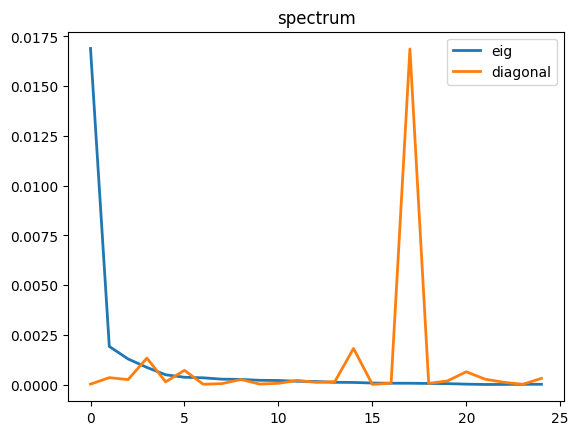

Test mean squared error after transformation: 0.37128250810329555
Simulation: 1
Test mean squared error before transformation: 0.35408031245813554


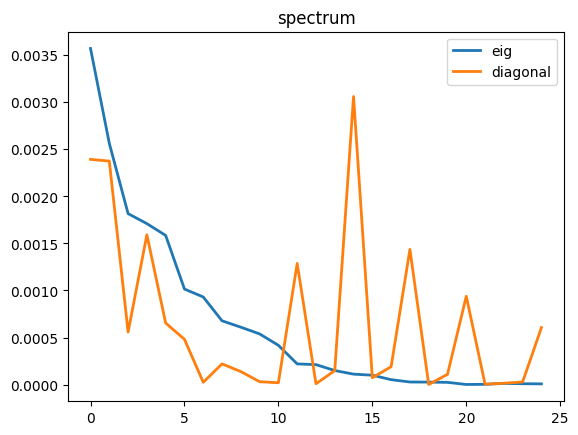

Test mean squared error after transformation: 0.34984281829668606
Simulation: 2
Test mean squared error before transformation: 0.35539855716416924


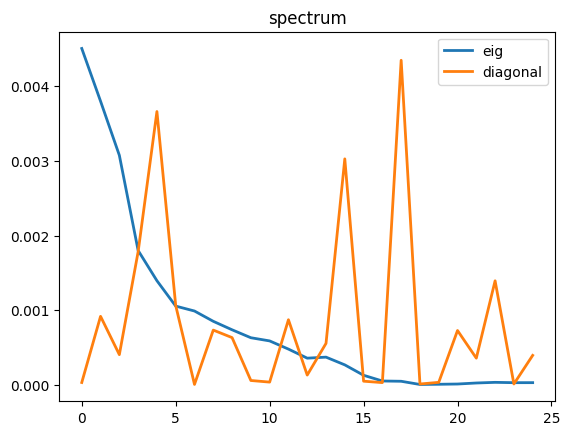

Test mean squared error after transformation: 0.35904816691119995
Simulation: 3
Test mean squared error before transformation: 0.3543341700066441


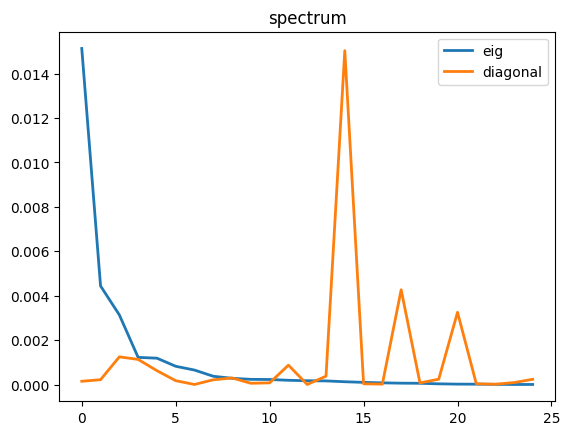

Test mean squared error after transformation: 0.36811706136982386
Simulation: 4
Test mean squared error before transformation: 0.35536032791976385


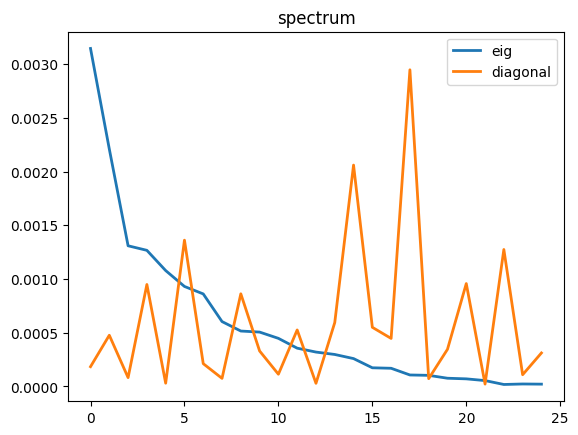

Test mean squared error after transformation: 0.369381103560253
number of training samples: 1000
Simulation: 0
Test mean squared error before transformation: 0.3458218677133622


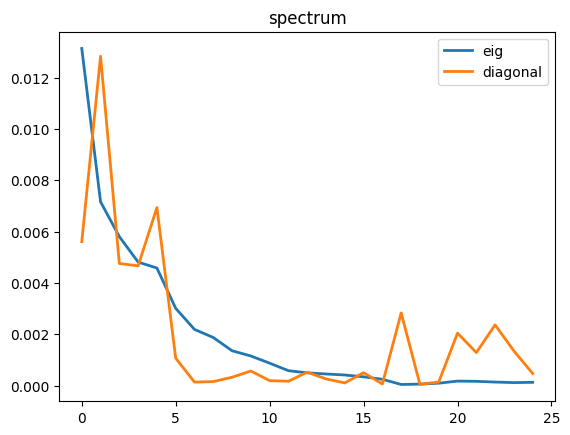

Test mean squared error after transformation: 0.3195872325324734
Simulation: 1
Test mean squared error before transformation: 0.3429805516860625


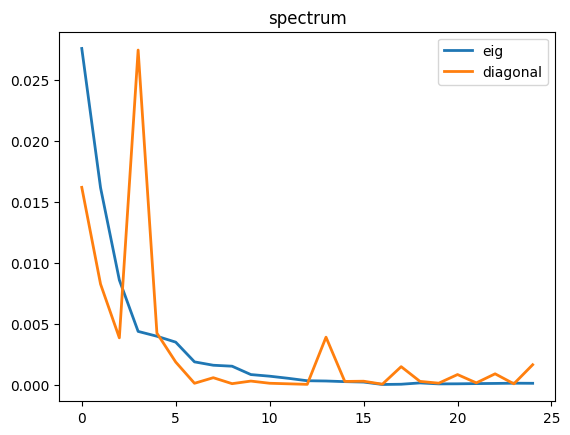

Test mean squared error after transformation: 0.31096647669749544
Simulation: 2
Test mean squared error before transformation: 0.3437972083119956


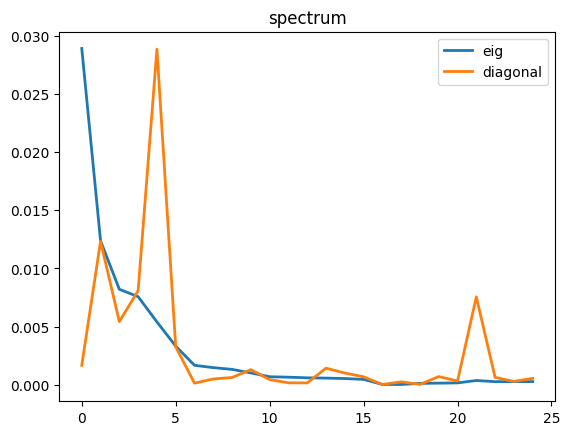

Test mean squared error after transformation: 0.31336472616564015
Simulation: 3
Test mean squared error before transformation: 0.34657438398312224


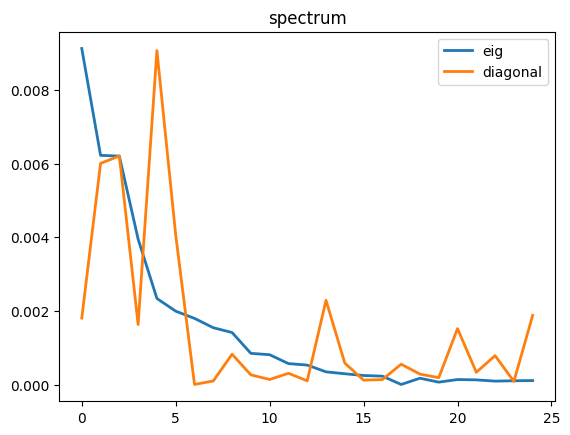

Test mean squared error after transformation: 0.32373159196393625
Simulation: 4
Test mean squared error before transformation: 0.34784637982589867


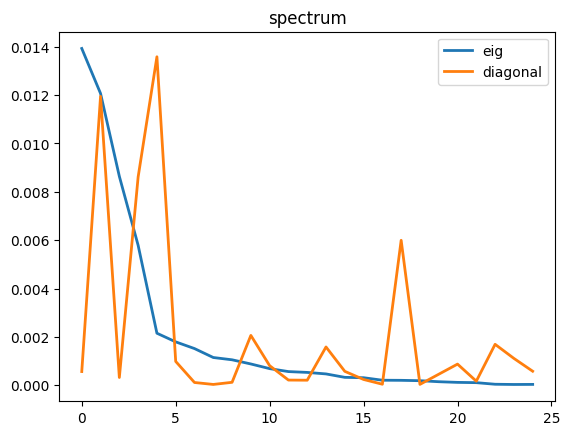

Test mean squared error after transformation: 0.3217915270289439
number of training samples: 5000
Simulation: 0
Test mean squared error before transformation: 0.34285432940388555


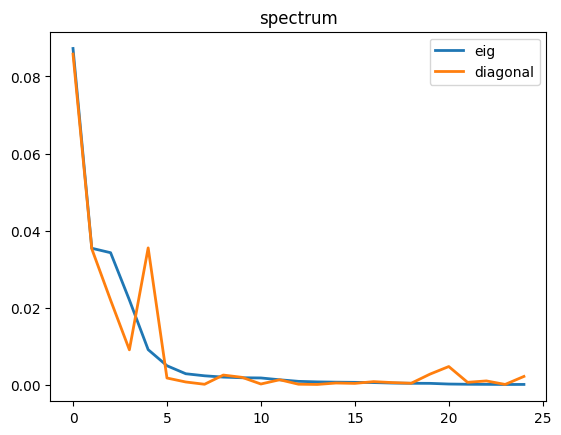

Test mean squared error after transformation: 0.3005277386492195
Simulation: 1
Test mean squared error before transformation: 0.34432129872740913


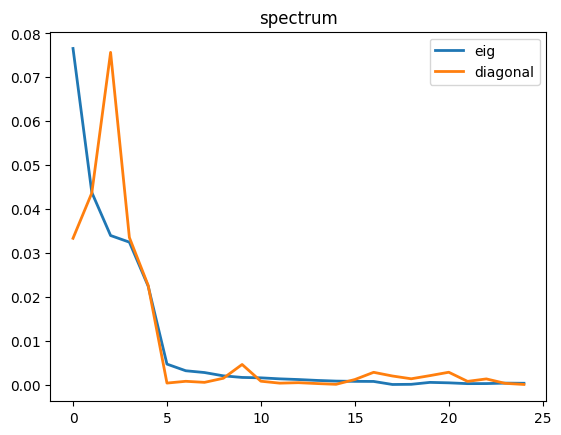

Test mean squared error after transformation: 0.30417002892900497
Simulation: 2
Test mean squared error before transformation: 0.34356793564558785


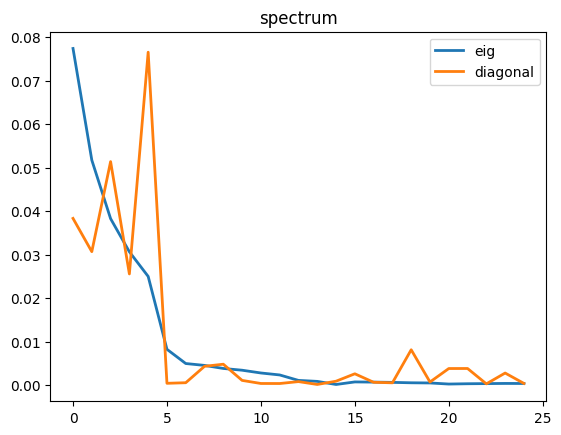

Test mean squared error after transformation: 0.30450182971140427
Simulation: 3
Test mean squared error before transformation: 0.3428608991858669


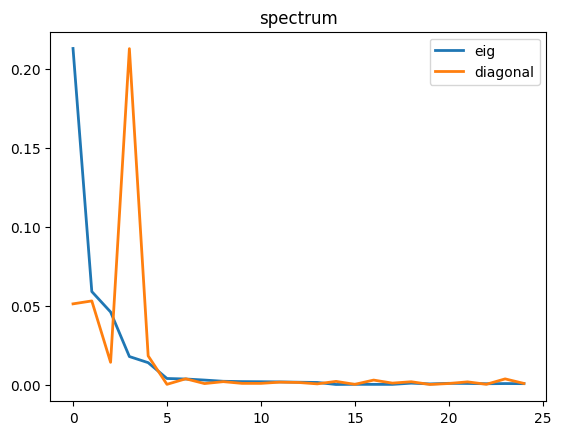

Test mean squared error after transformation: 0.307017488351917
Simulation: 4
Test mean squared error before transformation: 0.3451251110611432


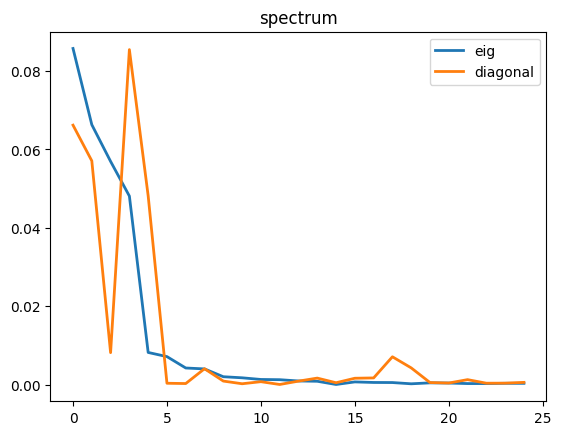

Test mean squared error after transformation: 0.30213744032579926
number of training samples: 10000
Simulation: 0
Test mean squared error before transformation: 0.3423743134559744


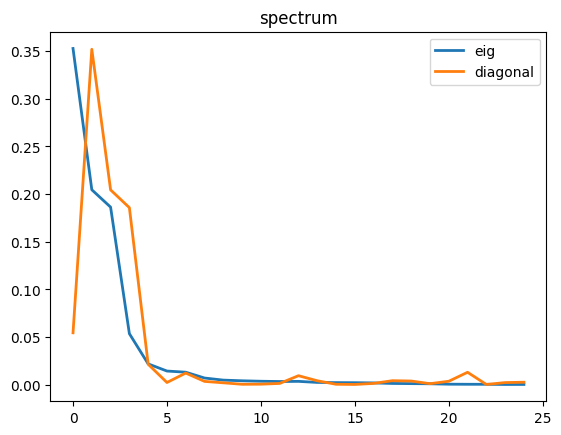

Test mean squared error after transformation: 0.3017355190490065
Simulation: 1
Test mean squared error before transformation: 0.34813743742322906


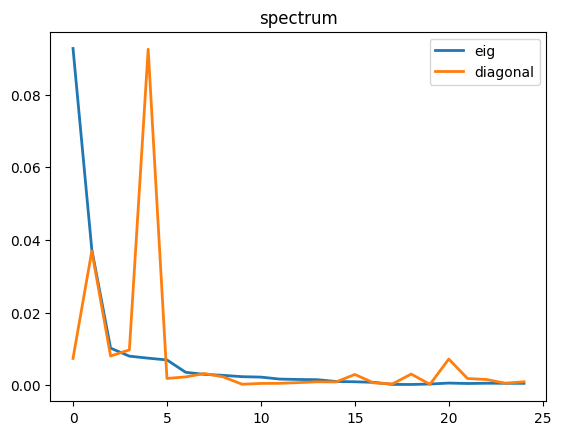

Test mean squared error after transformation: 0.3073568391599474
Simulation: 2
Test mean squared error before transformation: 0.3442909127741553


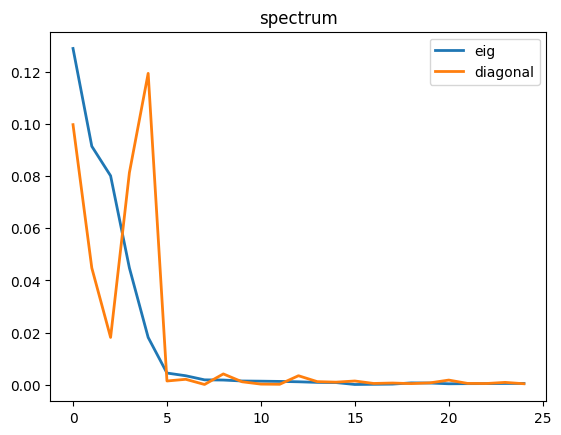

Test mean squared error after transformation: 0.29833532144677094
Simulation: 3
Test mean squared error before transformation: 0.3430563850603834


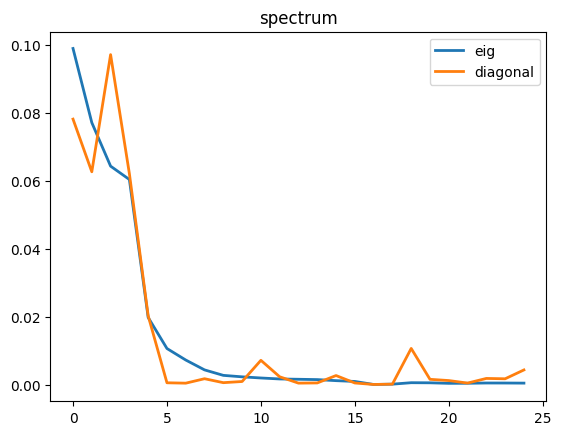

Test mean squared error after transformation: 0.3076751598522594
Simulation: 4
Test mean squared error before transformation: 0.3450672463003471


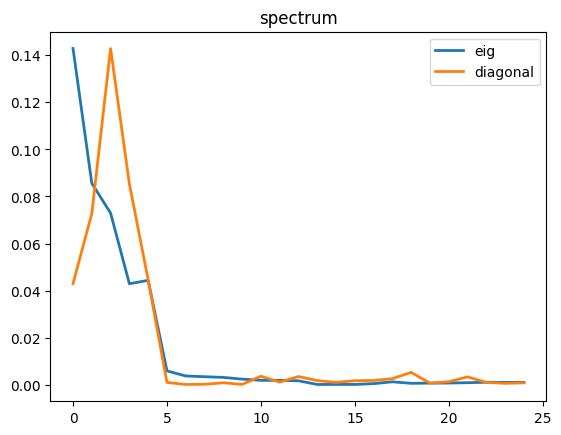

Test mean squared error after transformation: 0.2980936987290398
number of training samples: 20000
Simulation: 0
Test mean squared error before transformation: 0.34562635654645585


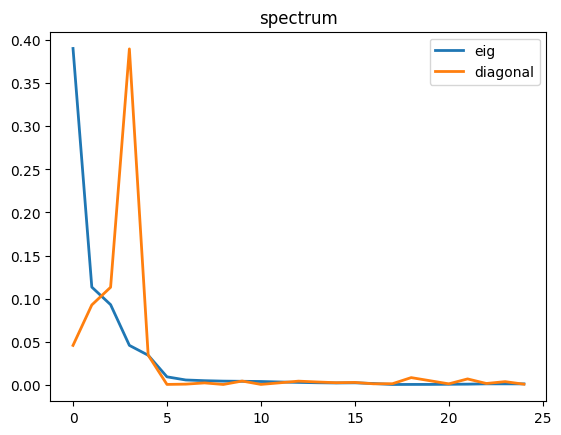

Test mean squared error after transformation: 0.30331933969418207
Simulation: 1
Test mean squared error before transformation: 0.34414198770640825


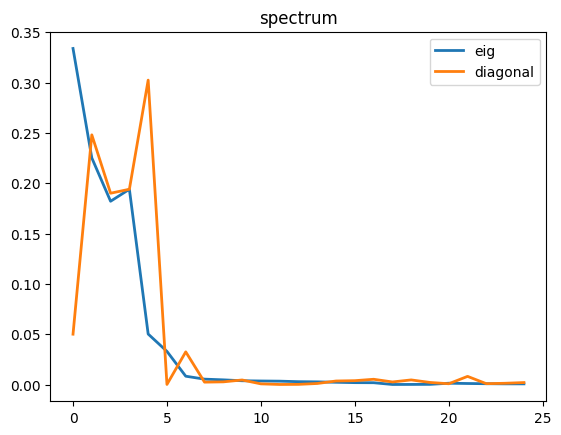

Test mean squared error after transformation: 0.30648095335929293
Simulation: 2
Test mean squared error before transformation: 0.3465216239021201


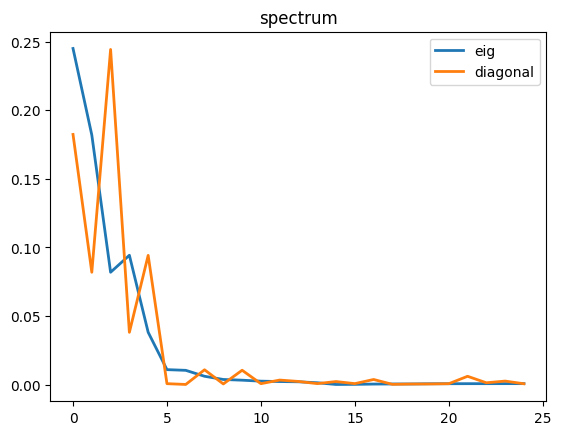

Test mean squared error after transformation: 0.30283190795399706
Simulation: 3
Test mean squared error before transformation: 0.34870756354933763


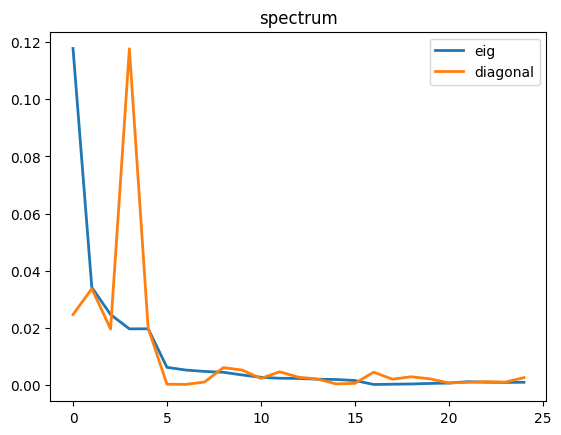

Test mean squared error after transformation: 0.3052257902604226
Simulation: 4
Test mean squared error before transformation: 0.34473688885042614


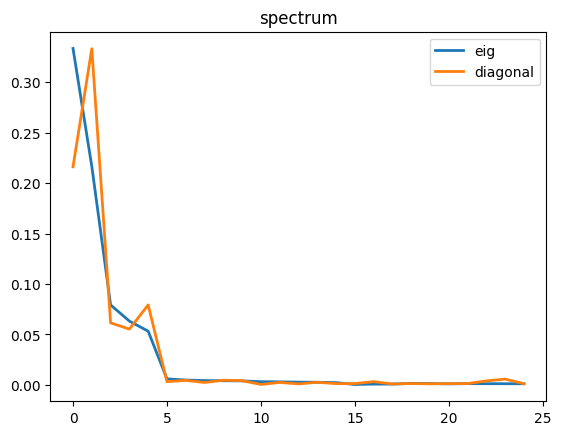

Test mean squared error after transformation: 0.2997098834659625


In [7]:
stats = []

for n_sim in [100, 1000, 5000, 10000, 20000]:
    print(f"number of training samples: {n_sim}")
    mse = {'n': n_sim, 'before': [], "after": []}
    for round in range(5):
        print(f"Simulation: {round}")
        mse_before, mse_after = simulate(x_train[:n_sim, ], y_train[:n_sim], x_test, y_test)
        mse['before'].append(mse_before)
        mse['after'].append(mse_after)
    stats.append(mse)

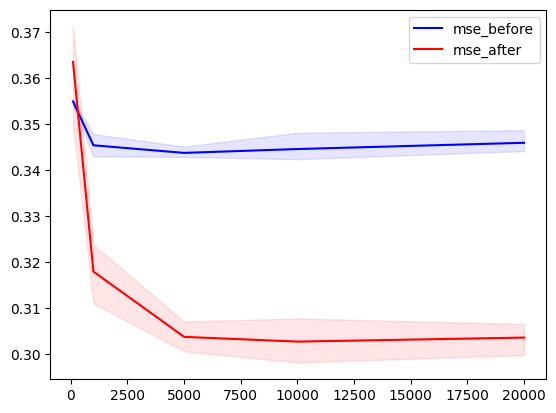

In [8]:
x = [100, 1000, 5000, 10000, 20000]
before = []
before_min = []
before_max = []
after = []
after_min = []
after_max = []

for stat in stats:
    before.append(np.mean(stat['before']))
    before_min.append(np.min(stat['before']))
    before_max.append(np.max(stat['before']))
    after.append(np.mean(stat['after']))
    after_min.append(np.min(stat['after']))
    after_max.append(np.max(stat['after']))

fig, ax = plt.subplots()
ax.plot(x, before, color='b')
ax.plot(x, after, color='r')
ax.fill_between(x, (before_min), (before_max), color='b', alpha=.1)
ax.fill_between(x, (after_min), (after_max), color='r', alpha=.1)

plt.legend(["mse_before", "mse_after"], loc ="upper right")

In [19]:
def simulate_best(x_train, y_train, x_test, y_test):
    x_train = x_train[:, 0:5]
    x_test= x_test[:, 0:5]
    _, _, history, w_kernel, _ = train(x_train, y_train, M, lifetime_max, delta, mondrian_kernel = True,
                                weights_from_lifetime=weights_lifetime)

    _, y_hat_test = evaluate(x_train, y_train, x_test, M, delta, history, w_kernel, mondrian_kernel = True, 
                                weights_from_lifetime=weights_lifetime)

    mse_best = mean_squared_error(y_test, y_hat_test)

    return mse_best

stats_best = []

for n_sim in [100, 1000, 5000, 10000, 20000]:
    print(f"number of training samples: {n_sim}")
    mse = {'n': n_sim, 'best': []}
    for round in range(5):
        print(f"Simulation: {round}")
        mse_best = simulate_best(x_train[:n_sim, ], y_train[:n_sim], x_test, y_test)
        mse['best'].append(mse_best)
        print(mse_best)
    stats_best.append(mse)

number of training samples: 100
Simulation: 0
0.33129876859660523
Simulation: 1
0.32797237586980926
Simulation: 2
0.3301099366392928
Simulation: 3
0.331860508586397
Simulation: 4
0.32880366025284435
number of training samples: 1000
Simulation: 0
0.3202517945633807
Simulation: 1
0.3227120908339215
Simulation: 2
0.31907535249250446
Simulation: 3
0.325955455440451
Simulation: 4
0.3194708232793885
number of training samples: 5000
Simulation: 0
0.32218618773645114
Simulation: 1
0.3202607931207013
Simulation: 2
0.31879523197803117
Simulation: 3
0.3245656296939608
Simulation: 4
0.3199811852040436
number of training samples: 10000
Simulation: 0
0.3198256877501421
Simulation: 1
0.3200701156530726
Simulation: 2
0.3259707440831123
Simulation: 3
0.32520963803980524
Simulation: 4
0.3225643110963731
number of training samples: 20000
Simulation: 0
0.3125379551903165
Simulation: 1
0.322836404720714
Simulation: 2
0.31787883348590096
Simulation: 3
0.31536279277838464
Simulation: 4
0.3221590673359867


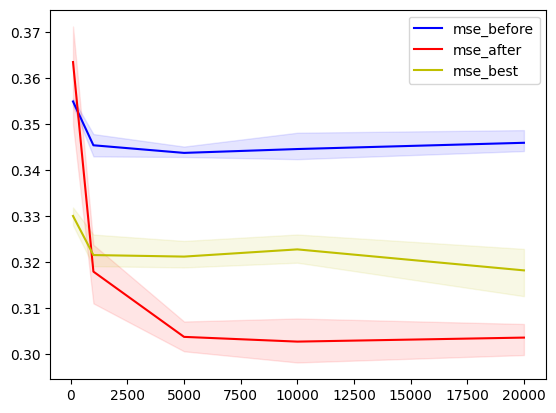

In [25]:
best = []
best_min = []
best_max = []

for stat in stats_best:
    best.append(np.mean(stat['best']))
    best_min.append(np.min(stat['best']))
    best_max.append(np.max(stat['best']))


fig, ax = plt.subplots()
ax.plot(x, before, color='b')
ax.plot(x, after, color='r')
ax.plot(x, best, color='y')
ax.fill_between(x, (before_min), (before_max), color='b', alpha=.1)
ax.fill_between(x, (after_min), (after_max), color='r', alpha=.1)
ax.fill_between(x, (best_min), (best_max), color='y', alpha=.1)

plt.legend(["mse_before", "mse_after", "mse_best"], loc ="upper right")

In [23]:
def simulate_double(x_train, y_train, x_test, y_test):
    x_train = x_train[:, 0:5]
    x_test= x_test[:, 0:5]
    lifetime_max = 0.2
    _, _, history, w_kernel, _ = train(x_train, y_train, M, lifetime_max, delta, mondrian_kernel = True,
                                weights_from_lifetime=weights_lifetime)

    _, y_hat_test = evaluate(x_train, y_train, x_test, M, delta, history, w_kernel, mondrian_kernel = True, 
                                weights_from_lifetime=weights_lifetime)

    mse_best = mean_squared_error(y_test, y_hat_test)

    return mse_best

stats_double = []

for n_sim in [100, 1000, 5000, 10000, 20000]:
    print(f"number of training samples: {n_sim}")
    mse = {'n': n_sim, 'best': []}
    for round in range(5):
        print(f"Simulation: {round}")
        mse_best = simulate_double(x_train[:n_sim, ], y_train[:n_sim], x_test, y_test)
        mse['best'].append(mse_best)
        print(mse_best)
    stats_double.append(mse)

number of training samples: 100
Simulation: 0
0.31074894161703315
Simulation: 1
0.3091995471313421
Simulation: 2
0.3148958043999524
Simulation: 3
0.31385893147937205
Simulation: 4
0.3167105401625122
number of training samples: 1000
Simulation: 0
0.2917126091002607
Simulation: 1
0.3067740466076247
Simulation: 2
0.30192785200902633
Simulation: 3
0.3057975659785208
Simulation: 4
0.30049026093532644
number of training samples: 5000
Simulation: 0
0.3029900355289319
Simulation: 1
0.3012907749326605
Simulation: 2
0.30386941267183576
Simulation: 3
0.30392287192658374
Simulation: 4
0.30223376299513527
number of training samples: 10000
Simulation: 0
0.30810693962077856
Simulation: 1
0.30779015661357323
Simulation: 2
0.3099645662294979
Simulation: 3
0.30548155557399237
Simulation: 4
0.3045559302850502
number of training samples: 20000
Simulation: 0
0.3037715957856174
Simulation: 1
0.2969514433402974
Simulation: 2
0.30567205482558446
Simulation: 3
0.30177631160032786
Simulation: 4
0.30139931475430

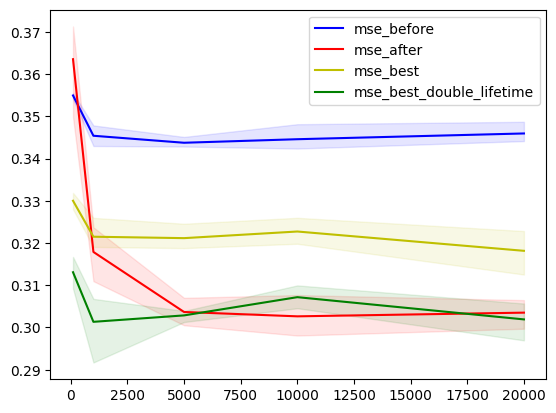

In [24]:
double = []
double_min = []
double_max = []

for stat in stats_double:
    double.append(np.mean(stat['best']))
    double_min.append(np.min(stat['best']))
    double_max.append(np.max(stat['best']))


fig, ax = plt.subplots()
ax.plot(x, before, color='b')
ax.plot(x, after, color='r')
ax.plot(x, best, color='y')
ax.plot(x, double, color='g')
ax.fill_between(x, (before_min), (before_max), color='b', alpha=.1)
ax.fill_between(x, (after_min), (after_max), color='r', alpha=.1)
ax.fill_between(x, (best_min), (best_max), color='y', alpha=.1)
ax.fill_between(x, (double_min), (double_max), color='g', alpha=.1)

plt.legend(["mse_before", "mse_after", "mse_best", "mse_best_double_lifetime"], loc ="upper right")